In [1]:
import psycopg2
import pandas as pd
import time
import seaborn as sns 
sns.set_palette("muted");
sns.set();
import matplotlib.pyplot as plt
import numpy as np
import mysql.connector
from influxdb import InfluxDBClient
import import_ipynb

from funktiot import *
Databases = []
connections = []
populate_db_times = []

importing Jupyter notebook from funktiot.ipynb


#### Huom! Jos tulee virhekoodeja, kun yrität yhdistää tietokantoihin. Konttien host-osoite saattaa muuttua, jos kontti on sammunut jossakin välissä.
#### Docker inspect -kontin_nimi-

#### YugabyteDB Connection

In [2]:
# real    33m26,826s
yugabyte = psycopg2.connect(host="172.19.0.1", 
                            port="5433", 
                            dbname="iiwari_org", 
                            user="yugabyte",
                            password="yugabyte")

populate_db_times.append(time_to_seconds("33m26,826s"))
Databases.append("YugabyteDB")
connections.append(yugabyte)

#### CockroachDB Connection

In [3]:
# real    0m26,160s
cockroach = psycopg2.connect(
                database="iiwari",
                user='roach',
                host='172.18.0.1',
                port="26257"
)

populate_db_times.append(time_to_seconds("0m26,160s"))
Databases.append("CockroachDB")
connections.append(cockroach)

### TimescaleDB Connection

In [4]:
# real    0m58,742s
timescaledb = psycopg2.connect(user = "postgres",
                              password = "password",
                              host = "172.17.0.1",
                              port = "5432",
                              dbname = "iiwari")

populate_db_times.append(time_to_seconds("0m58,742s"))
Databases.append("TimescaleDB")
connections.append(timescaledb)

### MariaDB Connection

In [5]:
# real    4m58,189s
mariadb = mysql.connector.connect(
    host="172.17.0.3",
    user="root",
    passwd="insert-password-here",
    database="iiwari_org"
)

Databases.append("MariaDB")
connections.append(mariadb) 
populate_db_times.append(time_to_seconds("4m58,189s"))

#### InfluxDB Connection

In [6]:
# real    11m22,010s
influxdb = InfluxDBClient(host='172.17.0.4', 
                        port=8086, 
                        username='admin', 
                        password='teamfox',
                        database="iiwari_org")


result = influxdb.query("Select * from SensorData limit 10")
cpu_points = list(result.get_points())
df = pd.DataFrame(list(cpu_points))

Databases.append("InfluxDB")
connections.append(influxdb)
populate_db_times.append(time_to_seconds("11m22,010s"))

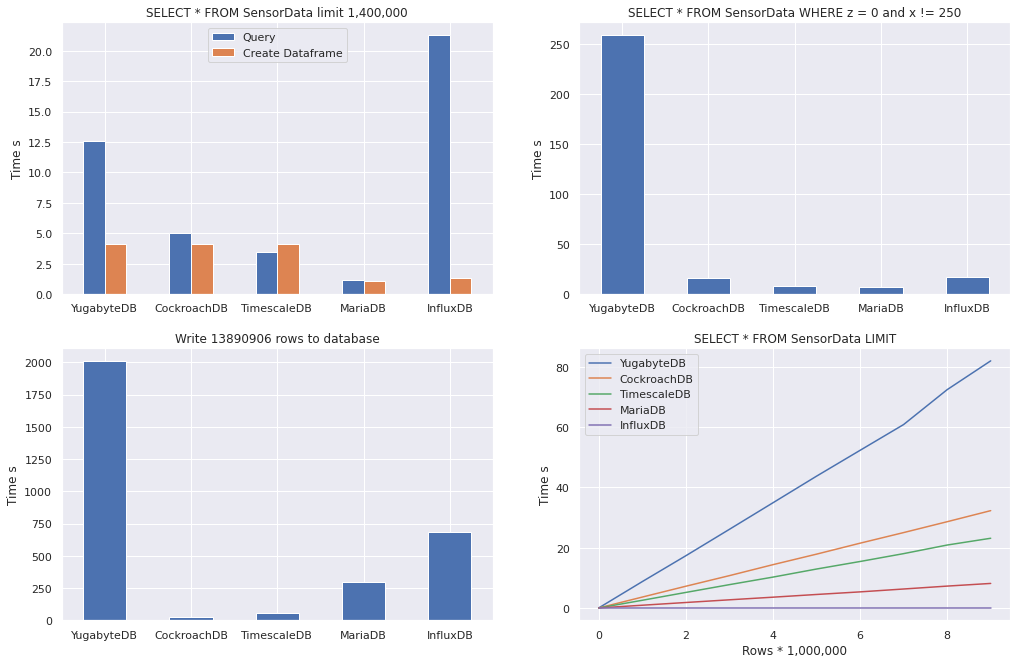

In [7]:
# Viiden databasen testit
db_speed_times = []
db_scalability_times = []
db_to_dataframe_tiems = []
db_speed_condition_times = []

speed_and_df_times = []
for connection in connections:
    speed_and_df_times = speed_test(connection, influxdb)
    db_speed_times.append(speed_and_df_times[0])
    db_to_dataframe_tiems.append(speed_and_df_times[1])
    db_scalability_times.append(scalability_test(connection, influxdb))
    db_speed_condition_times.append(speed_test_condition(connection, influxdb))

# Kuvaajat
get_graphs(db_speed_times, db_to_dataframe_tiems, db_speed_condition_times, db_scalability_times, Databases, populate_db_times)

In [9]:
# Jatketaan ilman InfluxDB ja YugabyteDB

top_3_db = Databases[1:-1]
top_3_connections = connections[1:-1]

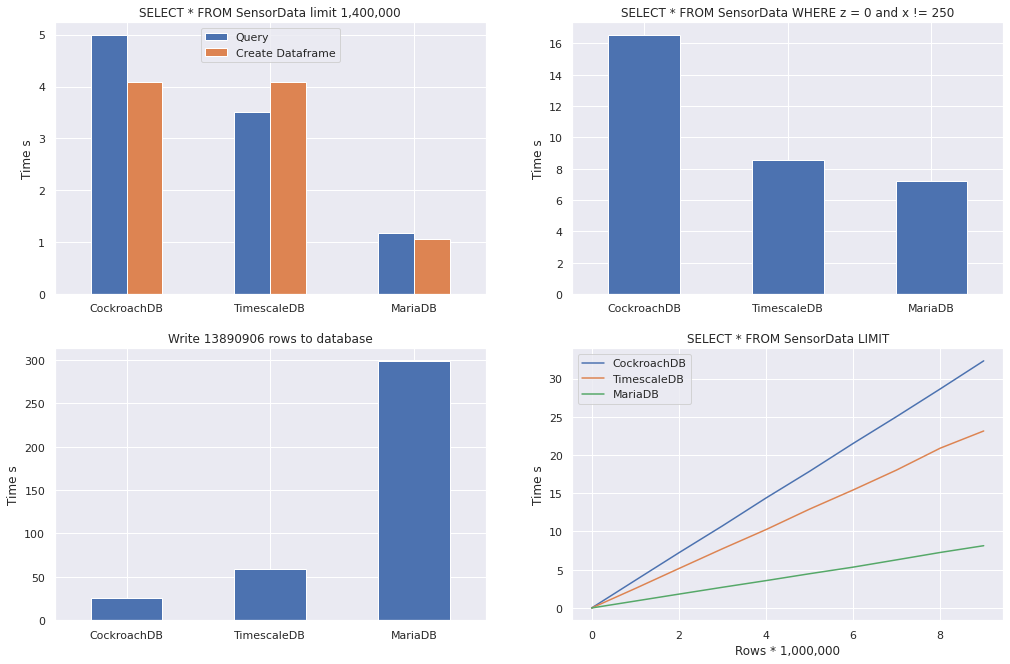

In [10]:
# Kolmen parhaan kuvaajat samasta testistä
get_graphs(db_speed_times[1:-1], db_to_dataframe_tiems[1:-1], db_speed_condition_times[1:-1], db_scalability_times[1:-1], Databases[1:-1], populate_db_times[1:-1])

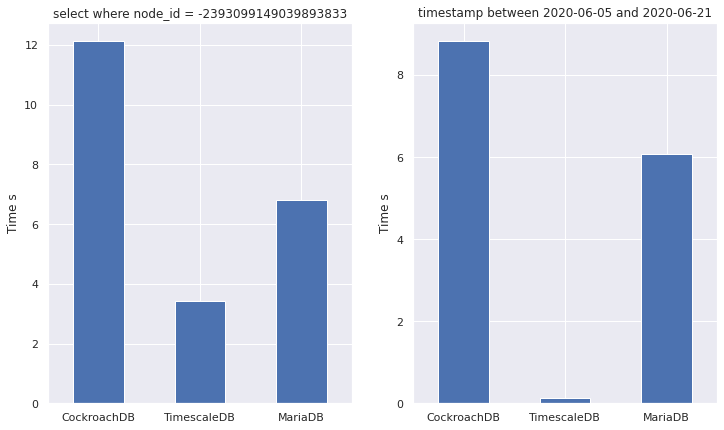

In [11]:
# Testataan node_id:n ja timestampin avulla hakemista ja plotataan kuvaaja
test_top_3(top_3_connections, top_3_db)